# Noise Cancellation Notebook

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import pywt
#from scipy import signal
from scipy.optimize import curve_fit

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import scipy 
import sounddevice as sd
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

# Record

In [ ]:
'''fs = 48000
second = 20

myrecording = sd.rec(int(second * fs),samplerate=fs)
sd.wait()
write('record/voice_test.wav')'''

In [75]:
data = pd.read_csv('Microsoft_Stock.csv')
data.Date = pd.to_datetime(data.Date)
data.head()

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


Text(0, 0.5, 'Close')

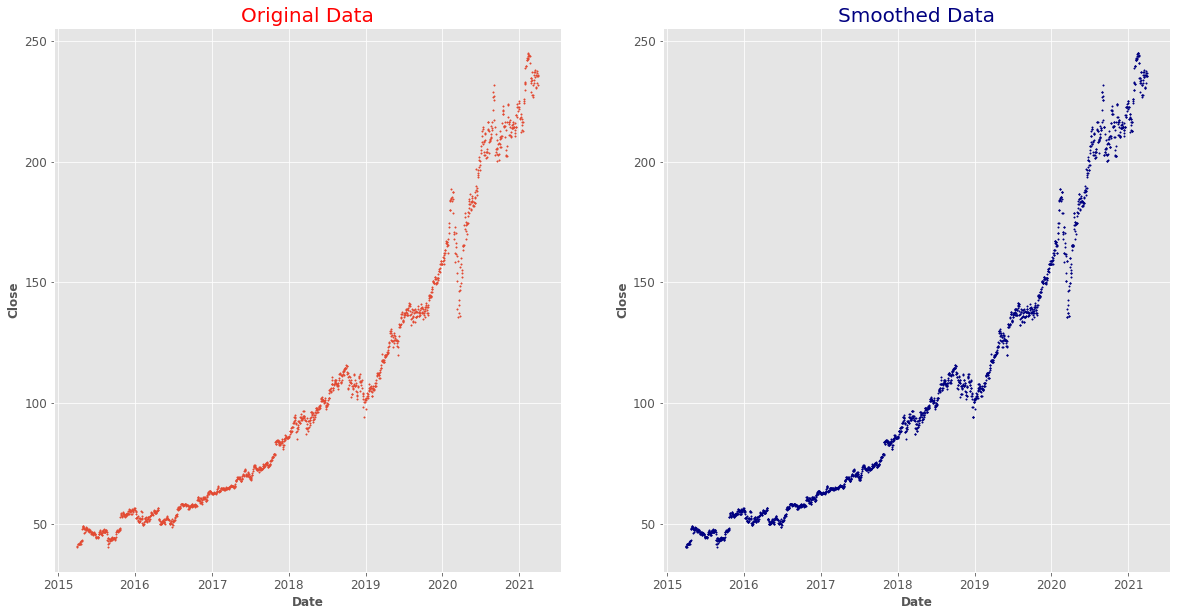

In [76]:
start_date = data.Date.loc[0]
end_date = data.Date.loc[len(data)-1]
start_year = start_date.year
start_month =  start_date.month
start_day = start_date.day
end_year = end_date.year
end_month =  end_date.month
end_day = end_date.day
number_of_days = abs((end_date-start_date).days)
start_date = datetime.date(start_date.year, start_date.month, start_date.day)
date_list = []
for day in range(number_of_days):
    a_date = (start_date + datetime.timedelta(days = day)).isoformat()
    date_list.append(a_date)
date_list = pd.to_datetime(date_list)
new_data = pd.DataFrame({'Date':date_list})
x = new_data.Date
old_x = data.Date
y = []
for i in range(len(x)):
    x_i = x.loc[i]
    diff_list = []
    for j in range(len(data)):
        diff_list.append(abs((x_i-old_x.loc[j]).days))
    diff_list = np.array(diff_list)
    y.append(data.Close[diff_list.argmin()])
        
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Original Data',color='red',fontsize=20)
plt.scatter(data.Date,data.Close,s=2)
plt.xlabel('Date')
plt.ylabel('Close')
plt.subplot(1,2,2)
plt.title('Smoothed Data',color='navy',fontsize=20)

plt.scatter(x,y,s=2,color='navy')
plt.xlabel('Date')
plt.ylabel('Close')

(2191,)


Text(0, 0.5, 'Price')

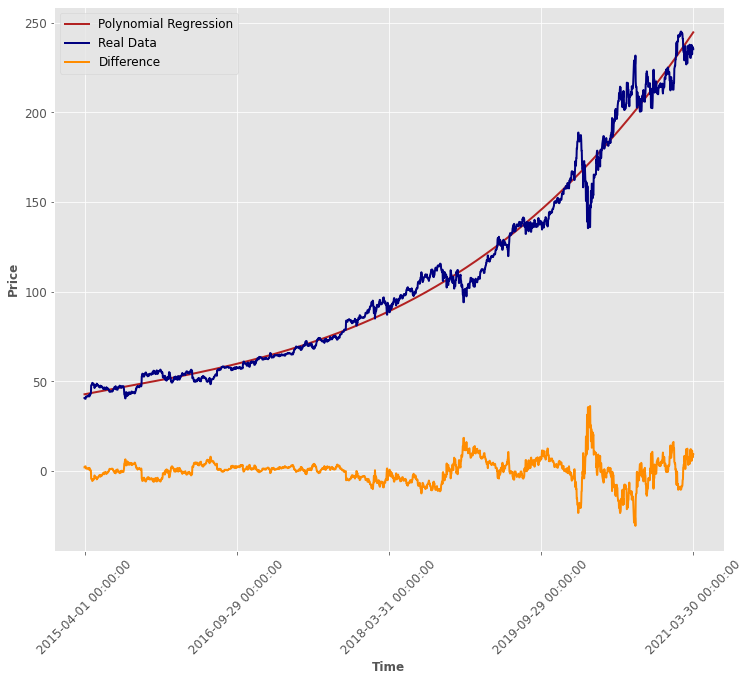

In [77]:
idx = np.linspace(0,len(x)-1,5).astype(int)
X = np.array(new_data.index).reshape(-1,1)
pf = PolynomialFeatures(3)
X = pf.fit_transform(X)
# y = 1 * x_0 + 2 * x_1 + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
print(x.shape)
plt.plot(x,reg.predict(X),label='Polynomial Regression',color='firebrick')
plt.plot(x,y,label='Real Data',color='navy')
plt.plot(x,reg.predict(X)-y,label='Difference',color='darkorange')
plt.legend()
plt.xticks(x[idx],x[idx],rotation=45)
plt.xlabel('Time')
plt.ylabel('Price')

## Fourier Approach

(2191,)


Text(0, 0.5, 'Fourier Amplitude')

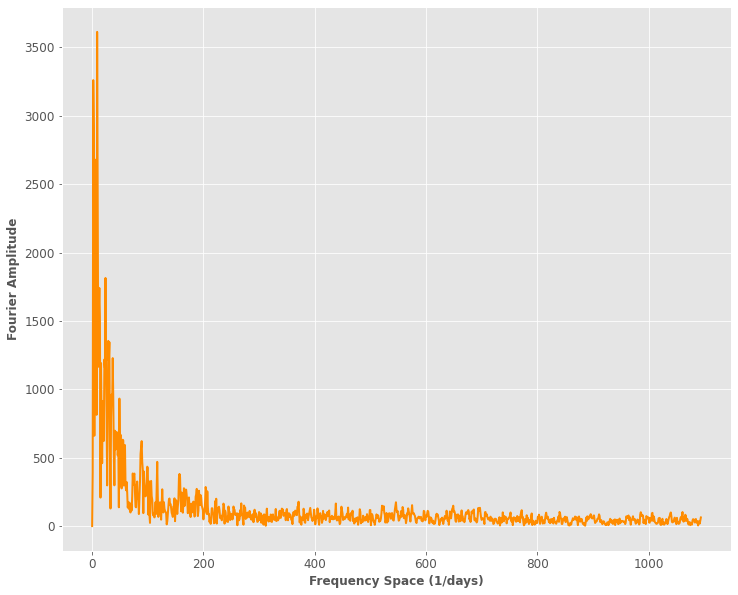

In [78]:
signal = reg.predict(X)-y
signal = signal-signal.mean()
print(signal.shape)
fft_signal = np.abs(np.fft.fft(signal))
plt.plot(fft_signal[0:int(len(signal)/2.)],color='darkorange')
plt.xlabel('Frequency Space (1/days)')
plt.ylabel('Fourier Amplitude')

In [79]:
new_Xph = [0 for x in range(1300)]
print(len(new_Xph))
def filter_signal(th):
    f_s = fft_filter(th)
    return np.real(np.fft.ifft(f_s))
def fft_filter(perc):
    fft_signal = np.fft.fft(signal)
    fft_abs = np.abs(fft_signal)
    th=perc*(2*fft_abs[0:int(len(signal)/2.)]/len(new_Xph)).max()
    fft_tof=fft_signal.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(new_Xph)
    fft_tof[fft_tof_abs<=th]=0
    return fft_tof
def fft_filter_amp(th):
    print(th)
    fft = np.fft.fft(signal)
    print(fft)
    fft_tof=fft.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(new_Xph)
    fft_tof_abs[fft_tof_abs<=th]=0
    return fft_tof_abs[0:int(len(fft_tof_abs)/2.)]

1300


0.0
[-6.75015599e-14+1.56319402e-13j  3.58653322e+02+1.54855519e+02j
 -3.08879737e+03-1.04341698e+03j ...  2.70169572e+03+1.08310700e+03j
 -3.08879737e+03+1.04341698e+03j  3.58653322e+02-1.54855519e+02j]
[2.61955396e-16 6.01009874e-01 5.01580655e+00 ... 2.82996570e-02
 6.58698398e-02 9.71846533e-02]
0.25
[-6.75015599e-14+1.56319402e-13j  3.58653322e+02+1.54855519e+02j
 -3.08879737e+03-1.04341698e+03j ...  2.70169572e+03+1.08310700e+03j
 -3.08879737e+03+1.04341698e+03j  3.58653322e+02-1.54855519e+02j]
[0.         0.60100987 5.01580655 ... 0.         0.         0.        ]
0.5
[-6.75015599e-14+1.56319402e-13j  3.58653322e+02+1.54855519e+02j
 -3.08879737e+03-1.04341698e+03j ...  2.70169572e+03+1.08310700e+03j
 -3.08879737e+03+1.04341698e+03j  3.58653322e+02-1.54855519e+02j]
[0.         0.60100987 5.01580655 ... 0.         0.         0.        ]
0.75
[-6.75015599e-14+1.56319402e-13j  3.58653322e+02+1.54855519e+02j
 -3.08879737e+03-1.04341698e+03j ...  2.70169572e+03+1.08310700e+03j
 -3.088

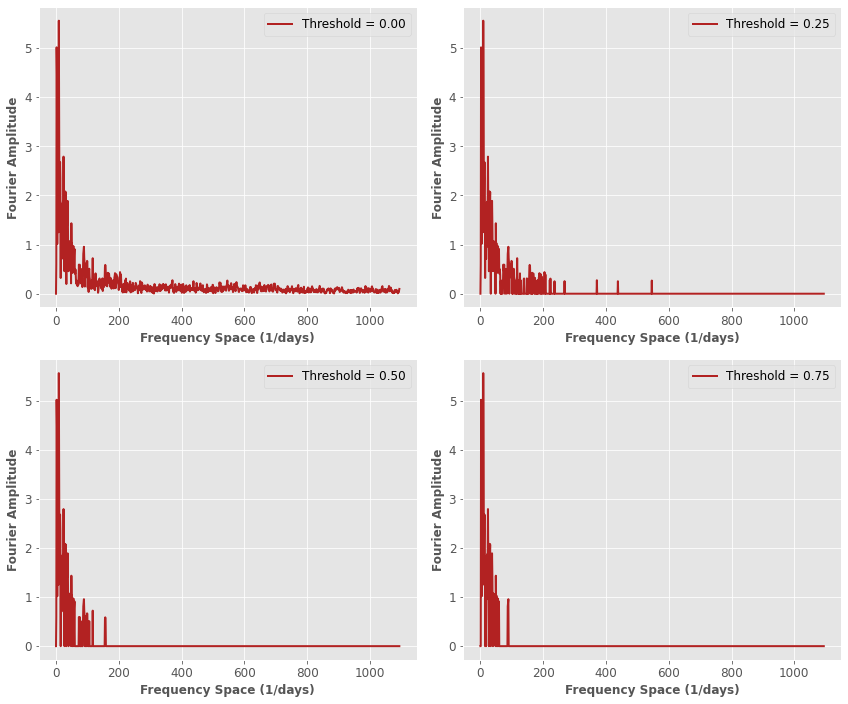

In [80]:
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]
for i in range(0,4):
    plt.subplot(2,2,i+1)
    th_i=th_list[i].round(2)
    
    th_filter = fft_filter_amp(th_i)
    print(th_filter)
    plt.plot(th_filter[0:int(len(signal)/2.)],color='firebrick',label='Threshold = %.2f'%(th_list[i]))
    plt.xlabel('Frequency Space (1/days)')
    plt.ylabel('Fourier Amplitude')
    plt.legend()
plt.tight_layout()

(2191,)
(2191,)
(2191,)
(2191,)
(2191,)
(2191,)
(2191,)
(2191,)


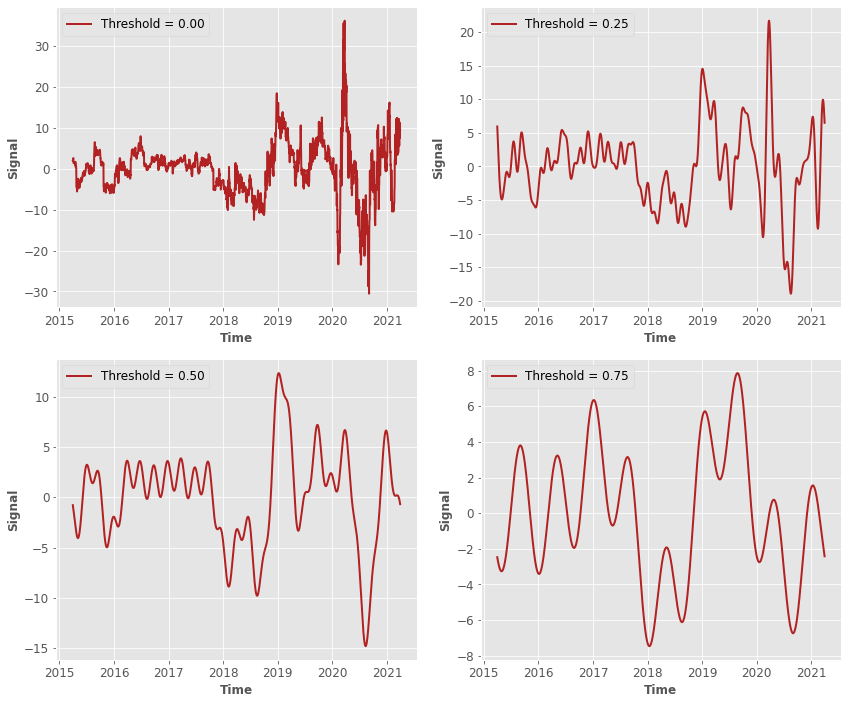

In [81]:
for i in range(0,4):
    plt.subplot(2,2,i+1)
    th_i=th_list[i].round(2)
    th_filter = fft_filter(th_i)
    signal_filter =np.real(np.fft.ifft(th_filter))
    print(x.shape)
    print(signal_filter.shape)
    plt.plot(x,signal_filter,color='firebrick',label='Threshold = %.2f'%(th_list[i]))
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend()
plt.tight_layout()

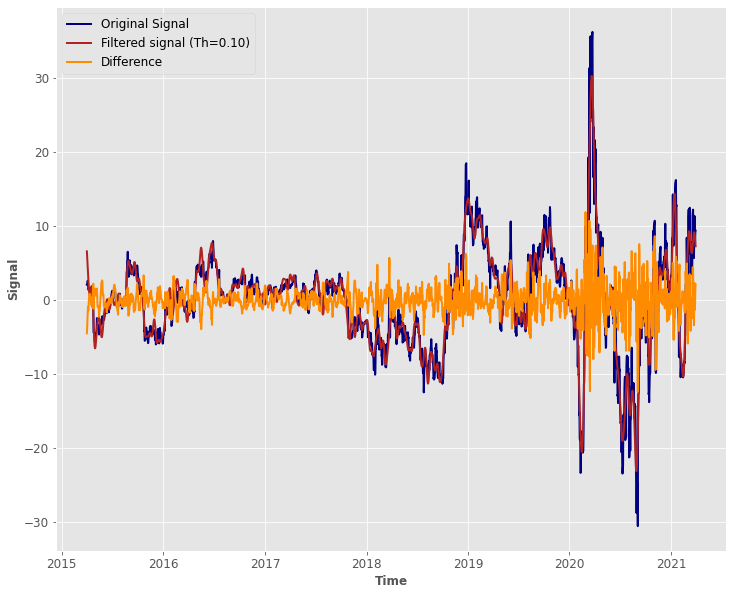

In [82]:
th_example_value = 0.10
example_signal = filter_signal(th_example_value)
plt.plot(x,signal,color='navy',label='Original Signal')
plt.plot(x,example_signal,color='firebrick',label='Filtered signal (Th=%.2f)'%(th_example_value))
plt.plot(x,signal-example_signal,color='darkorange',label='Difference')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()

Text(0.5, 0, 'Threshold Value')

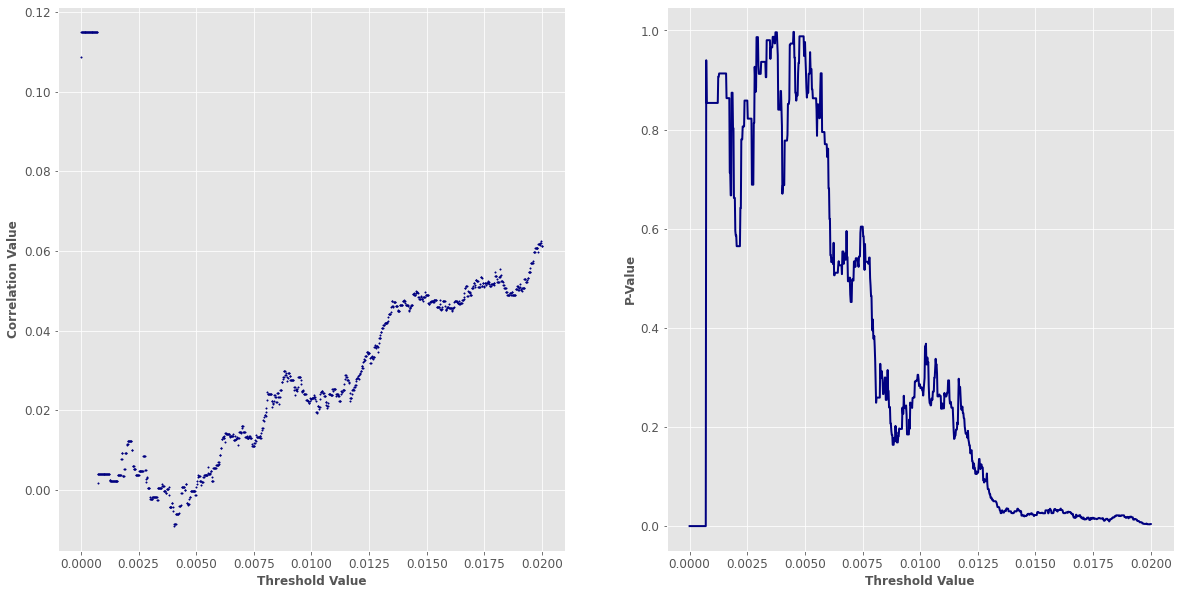

In [83]:
th_list = np.linspace(0,0.02,1000)
th_list = th_list[0:len(th_list)]
p_values = []
corr_values = []
for t in th_list:
    filt_signal = filter_signal(t)
    res = stats.spearmanr(signal,signal-filt_signal)
    p_values.append(res.pvalue)
    corr_values.append(res.correlation)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(th_list,corr_values,s=2,color='navy')
#plt.plot(th_list,p_values)
plt.ylabel('Correlation Value')
plt.xlabel('Threshold Value')
plt.subplot(1,2,2)
plt.plot(th_list,p_values,color='navy')
#plt.plot(th_list,p_values)
plt.ylabel('P-Value')
plt.xlabel('Threshold Value')

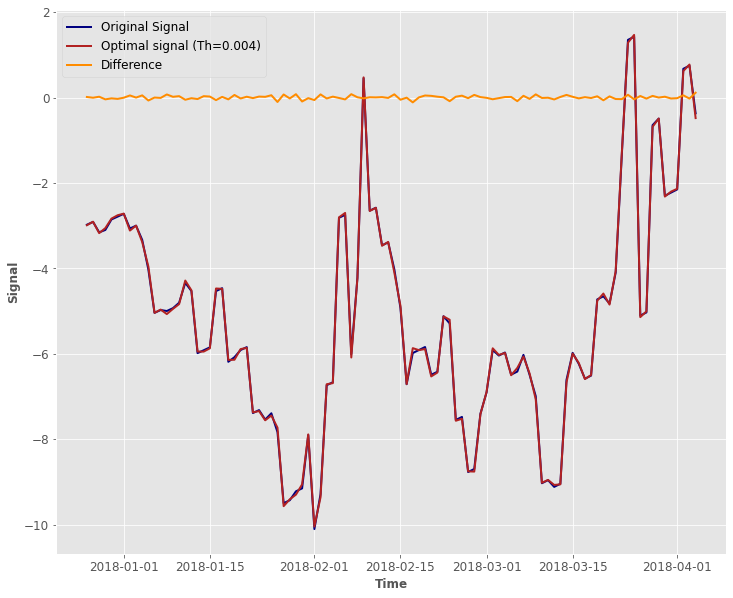

In [84]:
th_opt = th_list[np.array(corr_values).argmin()]
opt_signal = filter_signal(th_opt)
plt.plot(x[1000:1100],signal[1000:1100],color='navy',label='Original Signal')
plt.plot(x[1000:1100],opt_signal[1000:1100],color='firebrick',label='Optimal signal (Th=%.3f)'%(th_opt))
plt.plot(x[1000:1100],(signal-opt_signal)[1000:1100],color='darkorange',label='Difference')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()

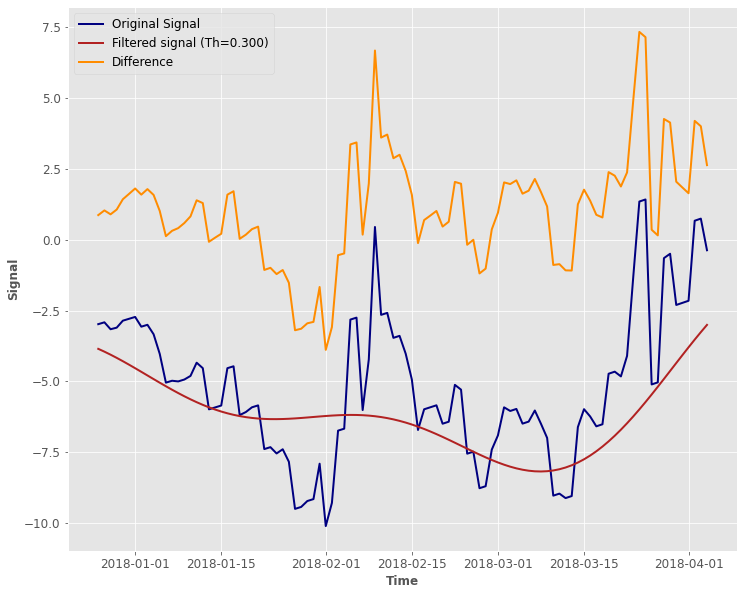

In [85]:
th_opt = th_list[np.array(corr_values).argmin()]
opt_signal = filter_signal(0.3)
plt.plot(x[1000:1100],signal[1000:1100],color='navy',label='Original Signal')
plt.plot(x[1000:1100],opt_signal[1000:1100],color='firebrick',label='Filtered signal (Th=%.3f)'%(0.3))
plt.plot(x[1000:1100],(signal-opt_signal)[1000:1100],color='darkorange',label='Difference')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()

## Wavelet Approach

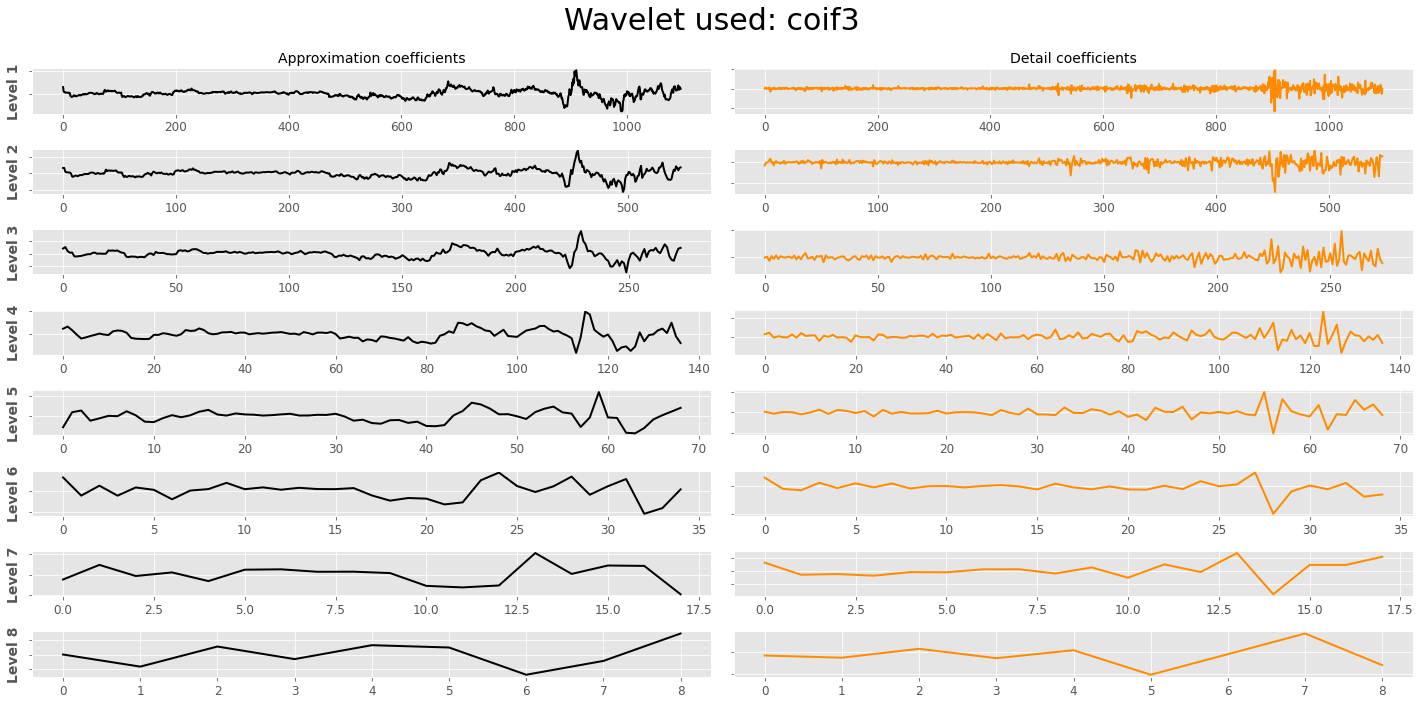

In [86]:
dataset = signal
waveletname = 'coif3'
levels=8
fig, axarr = plt.subplots(nrows=levels, ncols=2, figsize=(20,10))
COEFF_D=[]
DATASET=[]
k=1
plt.suptitle('Wavelet used: %s'%(waveletname),fontsize=30)
for ii in range(levels):
    (dataset, coeff_d) = pywt.dwt(dataset, waveletname,mode='per')
    axarr[ii, 0].plot(dataset, 'black')
    axarr[ii, 1].plot(coeff_d, 'darkorange')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    #print(len(coeff_d))
    COEFF_D.append(np.repeat(coeff_d,2**k))
    DATASET.append(np.repeat(dataset,2**k))
    k=k+1
plt.tight_layout()
plt.show()

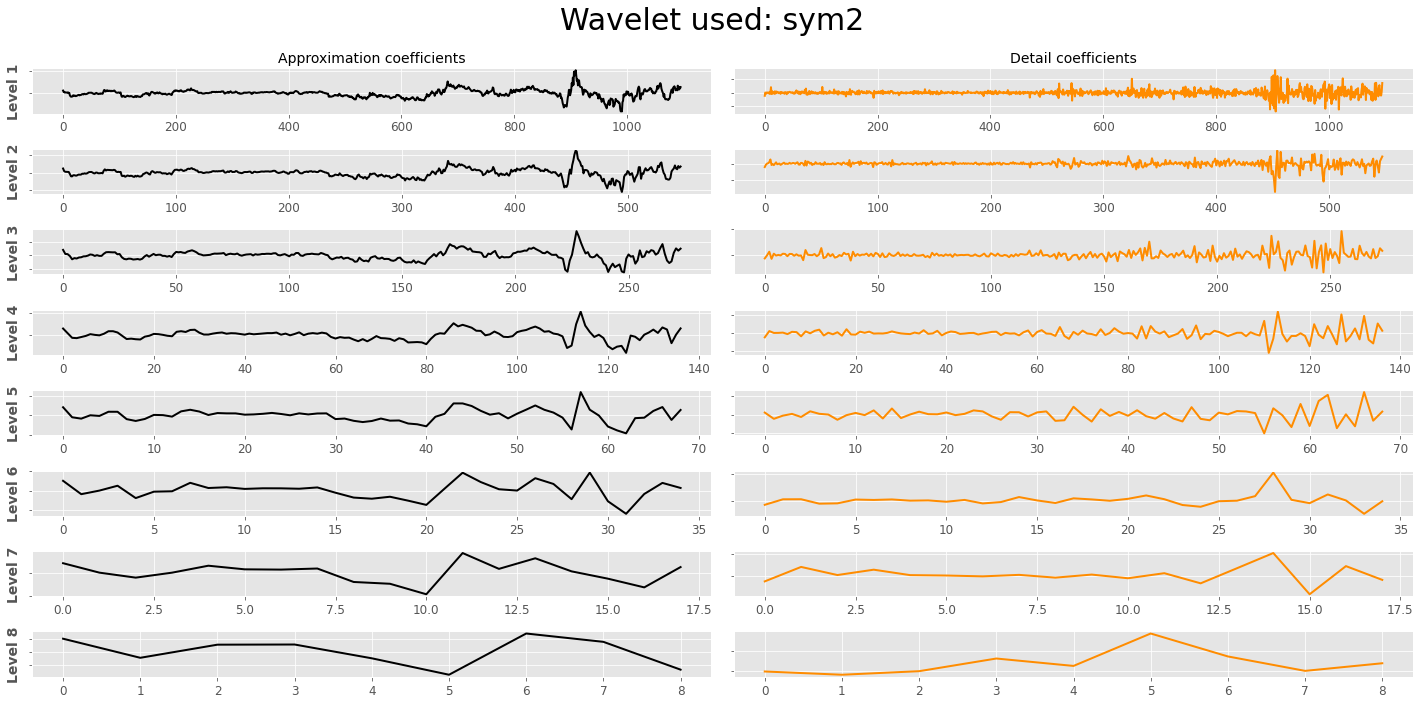

In [87]:
dataset = signal
waveletname = 'sym2'
levels=8
fig, axarr = plt.subplots(nrows=levels, ncols=2, figsize=(20,10))
COEFF_D=[]
DATASET=[]
k=1
plt.suptitle('Wavelet used: %s'%(waveletname),fontsize=30)
for ii in range(levels):
    (dataset, coeff_d) = pywt.dwt(dataset, waveletname,mode='per')
    axarr[ii, 0].plot(dataset, 'black')
    axarr[ii, 1].plot(coeff_d, 'darkorange')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    #print(len(coeff_d))
    COEFF_D.append(np.repeat(coeff_d,2**k))
    DATASET.append(np.repeat(dataset,2**k))
    k=k+1
plt.tight_layout()
plt.show()

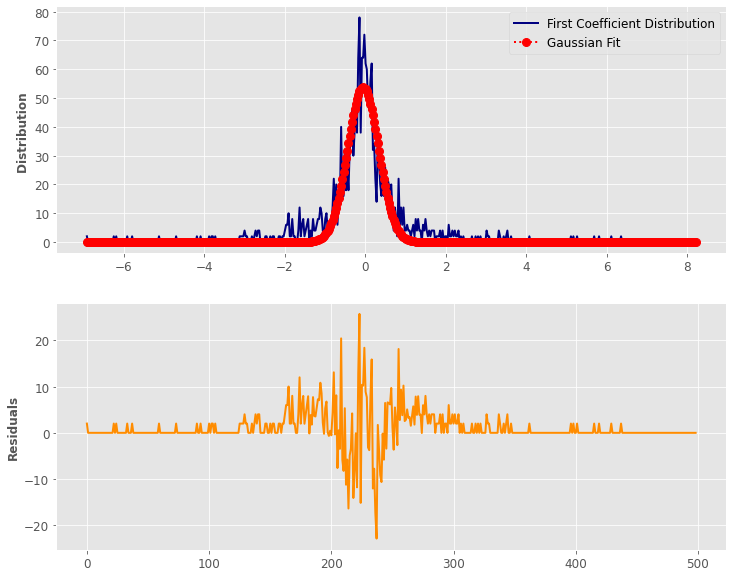

In [88]:
def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
x=np.histogram(COEFF_D[0],500)[1][0:500]
y=np.histogram(COEFF_D[0],500)[0]
def takeClosest(num,collection):
    collection=collection.tolist()
    collection=np.array(collection)
    if num>=0:
        collection=np.abs(collection[np.where(collection>0)])
        a= min(collection,key=lambda x:abs(x-abs(num)))
    else:
        collection=np.abs(collection[np.where(collection<0)])

        a= -min(collection,key=lambda x:abs(x-abs(num)))
    return a
x_try=x
b=x.tolist().index(takeClosest(500,x))
a=x.tolist().index(takeClosest(-500,x))
x=x[a:b]
y=y[a:b]


val_medio=x[int(len(x)/2)]
n = len(x)                       #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-val_medio)**2)/n        #note this correction
p0 = [max(y),val_medio,10]
popt,pcov = curve_fit(gaus,x,y,p0=p0)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_ylabel('Distribution ')
ax1.plot(x,y,'navy',label='First Coefficient Distribution')
ax1.grid(True)
plt.ylabel('Residuals')
ax1.plot(x,gaus(x,*popt),'ro:',label='Gaussian Fit')
ax1.legend()
res = y - gaus(x,*popt)
ax2.plot(res,color='darkorange')
ax2.grid(True)
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/audio_test/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/audio_test/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


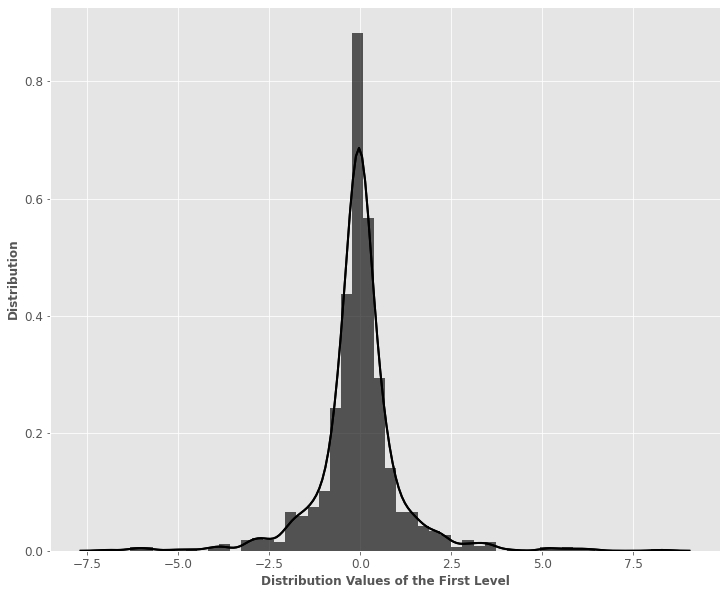

In [89]:
x=sns.distplot(COEFF_D[0],color='k').get_lines()[0].get_data()[0][a:b]
y=sns.distplot(COEFF_D[0],color='k').get_lines()[0].get_data()[1][a:b]
plt.ylabel('Distribution')
plt.xlabel('Distribution Values of the First Level')
plt.grid(True)

In [90]:
TH = np.arange(0.0,100,0.1)
C_TH=[]
for t in TH:
    rec=recons_from_th_zero(t)
    rec = rec[1::]
    C_TH.append(np.abs(np.corrcoef(rec-test,test)[0][1]))

plt.plot(TH[0:150],C_TH[0:150])
plt.xlabel('$\Theta$')
plt.ylabel('Difference-Signal Correlation')

NameError: name 'recons_from_th_zero' is not defined

(0.0, 180.0)

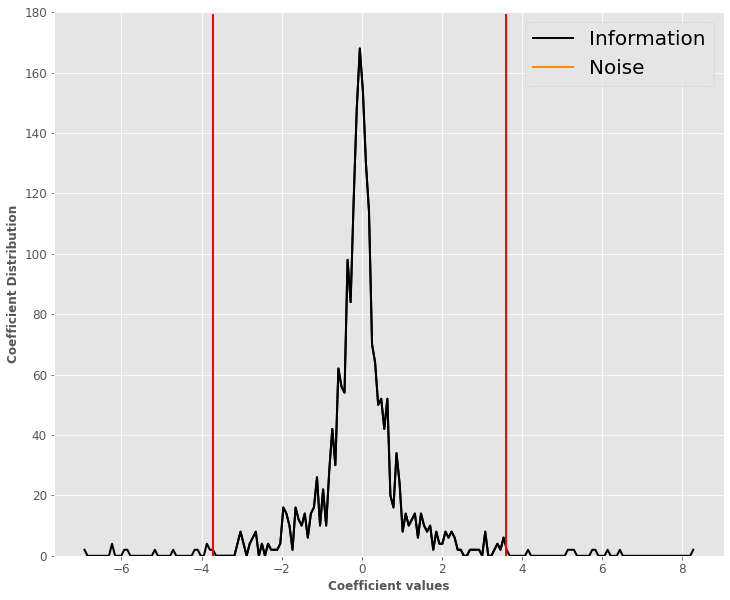

In [ ]:
Theta = TH[C_TH.index(min(C_TH))]
rec = recons_from_th_zero(Theta)
mean=popt[1]
lim_neg=mean-Theta*Sigma
lim_pos=mean+Theta*Sigma
lim_1=-Theta*Sigma
lim_2=-lim_1
coeff_0=np.array(COEFF_D[0].copy())
x_hist=np.histogram(coeff_0,199)[1]
y_hist=np.histogram(coeff_0,200)[0]
filt_coeff_0=coeff_0[np.where((coeff_0<lim_2) & (coeff_0>lim_1))]
x_left=x_hist[np.where((x_hist<lim_neg) & (x_hist>-500))]
x_right=x_hist[np.where(x_hist>lim_pos)]
y_left=y_hist[np.where((x_hist<lim_neg) & (x_hist>-500))]
y_right=y_hist[np.where(x_hist>lim_pos)]
x_mid=x_hist[np.where((x_hist>lim_neg) & (x_hist<lim_pos))]
y_mid=y_hist[np.where((x_hist>lim_neg) & (x_hist<lim_pos))]
plt.plot(x_left,y_left,color='k')
plt.plot(x_right,y_right,color='k',label='Information')
plt.plot(x_mid,y_mid,color='darkorange',label='Noise')
plt.plot(np.zeros(180)+lim_neg,np.arange(0,180),color='red')
plt.plot(np.zeros(180)+lim_pos,np.arange(0,180),color='red')

plt.grid(True)
plt.xlabel('Coefficient values')
plt.ylabel('Coefficient Distribution')
plt.legend(fontsize=20)
plt.ylim(0,180)

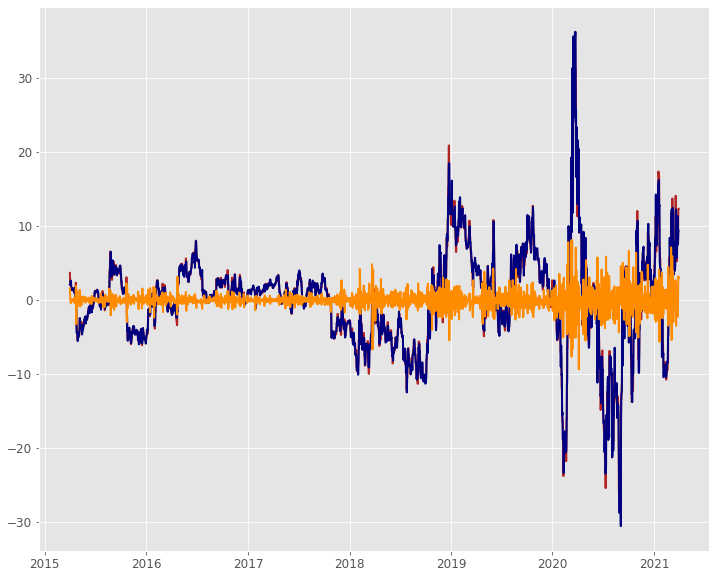

In [ ]:
x = new_data.Date
plt.plot(x,rec[1::],color='firebrick',label='Reconstruction')
plt.plot(x,signal,color='navy',label='Signal')
plt.plot(x,rec[1::]-signal,color='darkorange',label='Difference')

In [ ]:
import jovian
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
